## Load modules

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import os
import glob
from PIL import Image
from geometry import extract_feature_pixels, calculate_height_difference
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Set input and output folders

In [19]:
in_folder_predictions=r'D:\Wagga\GSV\Pano_clipped_predicted'
in_folder_depth=r'D:\Wagga\GSV\Depth_clipped'
building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta.geojson'

## Read in metadata file

In [20]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,Ground_surveyed,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,0,OhWlnnBJMpUtuvp3gak-8Q,-35.102543,147.349046,0.169123,-0.014912,6.252468,181.957260,2019-09,POINT (147.34855 -35.1025)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (147.34797 -35.10244)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (147.34698 -35.10443)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,0,BLJvkN33DWrwpEKVa7q-wQ,-35.104924,147.348552,0.161009,0.002666,6.254132,181.549530,2019-09,POINT (147.34792 -35.10482)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,0,PoUl3uYBjG4p2dgCVbWo9g,-35.103220,147.348914,0.147912,0.003101,6.249268,181.555573,2019-09,POINT (147.34845 -35.10319)


## Read in segmentation and depth files

In [21]:
prediction_files = glob.glob(os.path.join(in_folder_predictions,'*.png'))
prediction_file=prediction_files[0]
lbl_arr = np.asarray(Image.open(prediction_file))

In [22]:
pano_id=os.path.basename(prediction_file).split('.')[0]
print(pano_id)

OhWlnnBJMpUtuvp3gak-8Q


In [23]:
depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
depth_arr=np.asarray(Image.open(depth_file))

## Calculate FFH/FFE
- 1:"foundation", 2:"front door", 3:"garage door", 4:"stairs"

In [24]:
# def estimate_FFH(elev_foundation_top=None, elev_foundation_bottom=None,elev_stairs_top=None, elev_stairs_bottom=None, elev_frontdoor_bottom=None,elev_garagedoor_bottom=None, elev_camera=None):
#     '''
#     Calculate FFH using elevations of available features
#     '''
#     elev_ground_features=[elev_stairs_bottom,elev_garagedoor_bottom,elev_foundation_bottom]
#     # filter out missing features
#     elev_ground_features=[elev for elev in elev_ground_features if elev is not None]
#     if not elev_ground_features:
#         return None
#     elev_ground=min(elev_ground_features)

#     # collect available floor-level features elevations
#     elev_floor_features=[elev_foundation_top,elev_stairs_top,elev_frontdoor_bottom]
#     # filter out missing values
#     elev_floor_features=[elev for elev in elev_floor_features if elev is not None]
#     if not elev_floor_features:
#         return None
#     # determine the highest floor level feature elevation
#     elev_floor=max(elev_floor_features)
    
#     if elev_floor<elev_ground:
#         return None
#     # calculate FFH
#     FFH=elev_floor-elev_ground
#     return FFH

In [25]:
def estimate_FFH(elev_foundation_top=None, elev_foundation_bottom=None,elev_stairs_top=None, elev_stairs_bottom=None, elev_frontdoor_bottom=None,elev_garagedoor_bottom=None, elev_camera=None):
    '''
    Calculate FFH using elevations of available features
    '''
    # determine ground elevation
    elev_ground=None
    if elev_garagedoor_bottom is not None:
        elev_ground=elev_garagedoor_bottom
    elif elev_stairs_bottom is not None:
        elev_ground=elev_stairs_bottom
    elif elev_foundation_bottom is not None:
        elev_ground=elev_foundation_bottom
    if elev_ground is None:
        return None
    
    elev_floor=None
    if elev_frontdoor_bottom is not None:
        elev_floor=elev_frontdoor_bottom
    elif elev_stairs_top is not None:
        elev_floor=elev_stairs_top
    elif elev_foundation_top is not None:
        elev_floor=elev_foundation_top
    if elev_floor is None:
        return None
    if elev_floor<elev_ground:
        return None
    # calculate FFH
    FFH=elev_floor-elev_ground
    return FFH

In [26]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_mask=(lbl_arr==1)
frontdoor_mask = (lbl_arr==2)
garagedoor_mask = (lbl_arr==3)
stairs_mask = (lbl_arr==4)
foundation_bottom_pixels = extract_feature_pixels(foundation_mask,extract="bottom")
stairs_bottom_pixels = extract_feature_pixels(stairs_mask, extract="bottom")
frontdoor_bottom_pixels = extract_feature_pixels(frontdoor_mask,extract="bottom")
garagedoor_bottom_pixels = extract_feature_pixels(garagedoor_mask,extract="bottom")

# extract top pixels of foundation and stairs
foundation_top_pixels = extract_feature_pixels(foundation_mask,extract="top")
stairs_top_pixels = extract_feature_pixels(stairs_mask,extract="top")


In [27]:
H_img = depth_arr.shape[0]  # Height of the cropped panorama
# calculate height difference between feature top/bottom and camera
delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
delata_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
delata_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)
FFH = estimate_FFH(elev_foundation_top=delata_foundation_top, 
                   elev_foundation_bottom=delta_foundation_bottom,
                   elev_stairs_top=delata_stairs_top, 
                   elev_stairs_bottom=delta_stairs_bottom, 
                   elev_frontdoor_bottom=delta_frontdoor_bottom,
                   elev_garagedoor_bottom=delta_garagedoor_bottom, 
                   elev_camera=None)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): None


In [28]:

# delta_camera_door = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
# print("Estimated Height difference between camera and door bottom:", delta_camera_door)
# delta_camera_base = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
# print("Estimated Height difference between camera and stairs bottom:", delta_camera_base)
# print("Estimated First Floor Height (FFH):", delta_camera_door-delta_camera_base)

## Batch calculte for all images

In [29]:
FFH_all_predicted=[]
pano_ids=[]
for prediction_file in prediction_files:
    pano_id=os.path.basename(prediction_file).split('.')[0]
    pano_ids.append(pano_id)
    print('pano id: ',pano_id)
    lbl_arr = np.asarray(Image.open(prediction_file))
    depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
    depth_arr=np.asarray(Image.open(depth_file))
    # extract bottom pixels of foundation, stairs, front door and garage door
    foundation_mask=(lbl_arr==1)
    frontdoor_mask = (lbl_arr==2)
    garagedoor_mask = (lbl_arr==3)
    stairs_mask = (lbl_arr==4)
    foundation_bottom_pixels = extract_feature_pixels(foundation_mask,extract="bottom")
    stairs_bottom_pixels = extract_feature_pixels(stairs_mask, extract="bottom")
    frontdoor_bottom_pixels = extract_feature_pixels(frontdoor_mask,extract="bottom")
    garagedoor_bottom_pixels = extract_feature_pixels(garagedoor_mask,extract="bottom")

    # extract top pixels of foundation and stairs
    foundation_top_pixels = extract_feature_pixels(foundation_mask,extract="top")
    stairs_top_pixels = extract_feature_pixels(stairs_mask,extract="top")
    H_img = depth_arr.shape[0]  # Height of the cropped panorama
    # calculate height difference between feature top/bottom and camera
    delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
    delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
    delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
    delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
    delata_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
    delata_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)
    FFH = estimate_FFH(elev_foundation_top=delata_foundation_top, 
                    elev_foundation_bottom=delta_foundation_bottom,
                    elev_stairs_top=delata_stairs_top, 
                    elev_stairs_bottom=delta_stairs_bottom, 
                    elev_frontdoor_bottom=delta_frontdoor_bottom,
                    elev_garagedoor_bottom=delta_garagedoor_bottom, 
                    elev_camera=None)
    FFH_all_predicted.append(FFH)
    print("Estimated First Floor Height (FFH):", FFH)

pano id:  OhWlnnBJMpUtuvp3gak-8Q
Estimated First Floor Height (FFH): None
pano id:  BLJvkN33DWrwpEKVa7q-wQ
Estimated First Floor Height (FFH): 0.017978895711631568
pano id:  PoUl3uYBjG4p2dgCVbWo9g
Estimated First Floor Height (FFH): None
pano id:  cRj7D5icRyy66mCT2OlseA
Estimated First Floor Height (FFH): 0.9375466728055344
pano id:  X8OuJO7ZYXI9MGvJ4Y5TEw
Estimated First Floor Height (FFH): 0.5329213787045076
pano id:  zE7CxHN89C2RI7W7EZn-og
Estimated First Floor Height (FFH): None
pano id:  dwTZUTHMHE57Fmc7HcoMRw
Estimated First Floor Height (FFH): None
pano id:  3Yf0HkNTsXhUfSx-G9nkrw
Estimated First Floor Height (FFH): None
pano id:  Gu61Mh1dxitAX7rm5wYiug
Estimated First Floor Height (FFH): None
pano id:  TL8qt0dfu-kzr7RFz_u2vQ
Estimated First Floor Height (FFH): None
pano id:  7Hq-MjlBBPIdKaMAR6Dy2A
Estimated First Floor Height (FFH): 0.32556973460321825
pano id:  FlVfvw-30PlotofhiodzIQ
Estimated First Floor Height (FFH): 0.10715477264939954
pano id:  MxYDlKf3OOJDK7GsKA8EZw
Estim

In [30]:
gdf_updated=gdf.copy()
pano_id_toFFH=dict(zip(pano_ids, FFH_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_toFFH)
out_file=building_point_file.replace('.geojson','_FFH_GSV.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


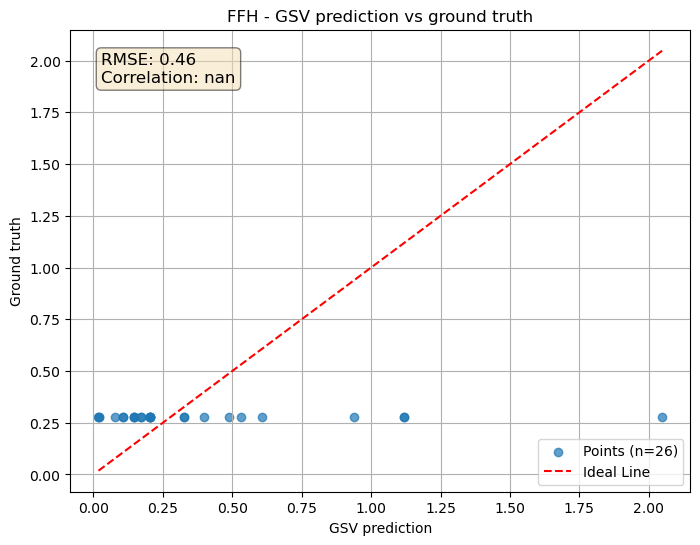

In [31]:
# Calculate RMSE
predicted=gdf_updated["FFH_GSV"]
gt=gdf_updated["Floor_height"]
valid_indices = ~np.isnan(predicted) & ~np.isnan(gt)
predicted = predicted[valid_indices]
gt = gt[valid_indices]

rmse = np.sqrt(mean_squared_error(predicted, gt))
# Calculate Correlation Coefficient
correlation = np.corrcoef(predicted, gt)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(predicted, gt, alpha=0.7, label=f'Points (n={len(predicted)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted.min(), predicted.max()], [predicted.min(), predicted.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('GSV prediction')
plt.ylabel('Ground truth')
plt.legend()
plt.grid()
# Show plot
plt.show()